In [8]:
from flygym.examples import cpg_controller

In [9]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import trange

save_dir = Path("outputs")
save_dir.mkdir(exist_ok=True)

In [10]:
# note that flygym.mujoco.<module> has been renamed to flygym.<module>
# (e.g., flygym.mujoco.preprogrammed -> flygym.preprogrammed)
from flygym.preprogrammed import all_leg_dofs
from flygym.util import get_data_path

run_time = 0.01
timestep = 1e-4
actuated_joints = all_leg_dofs

data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep

for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

In [11]:
from flygym import Fly, Camera, SingleFlySimulation
from flygym.arena import complex_terrain as ct
from flygym.arena import base as ba
from flygym.examples import obstacle_arena as oa
from flygym import preprogrammed as pp
import matplotlib.pyplot as plt

In [12]:
from flygym.preprogrammed import get_collision_geometries

In [13]:
floor_contacts = get_collision_geometries("legs")
floor_contacts += ["Head", "LPedicel", "LFuniculus", "RPedicel", "RFuniculus", "LArista", "RArista"]

In [14]:
floor_contacts

['LFCoxa',
 'LFFemur',
 'LFTibia',
 'LFTarsus1',
 'LFTarsus2',
 'LFTarsus3',
 'LFTarsus4',
 'LFTarsus5',
 'LMCoxa',
 'LMFemur',
 'LMTibia',
 'LMTarsus1',
 'LMTarsus2',
 'LMTarsus3',
 'LMTarsus4',
 'LMTarsus5',
 'LHCoxa',
 'LHFemur',
 'LHTibia',
 'LHTarsus1',
 'LHTarsus2',
 'LHTarsus3',
 'LHTarsus4',
 'LHTarsus5',
 'RFCoxa',
 'RFFemur',
 'RFTibia',
 'RFTarsus1',
 'RFTarsus2',
 'RFTarsus3',
 'RFTarsus4',
 'RFTarsus5',
 'RMCoxa',
 'RMFemur',
 'RMTibia',
 'RMTarsus1',
 'RMTarsus2',
 'RMTarsus3',
 'RMTarsus4',
 'RMTarsus5',
 'RHCoxa',
 'RHFemur',
 'RHTibia',
 'RHTarsus1',
 'RHTarsus2',
 'RHTarsus3',
 'RHTarsus4',
 'RHTarsus5',
 'Head',
 'LPedicel',
 'LFuniculus',
 'RPedicel',
 'RFuniculus',
 'LArista',
 'RArista']

In [15]:
# most of the parameters previously passed to Parameters are now passed to Fly.
# check the documentation for more details.
fly = Fly(
    spawn_pos=(0, 0, 0.5),
    actuated_joints=actuated_joints,
    contact_sensor_placements=["LArista", "RArista"],
    # floor_collisions=floor_contacts,
)

cameras = [
    Camera(fly=fly, camera_id=f"Animat/camera_{side}", window_size=(256, 256))
    for side in ["left", "right", "top", "front", "head_zoomin", "left_top_zoomout"]
]

cam = Camera(
    fly=fly,
    # camera_id="Animat/camera_head_zoomin",
    camera_id="Animat/camera_front_zoomout_long",
)

# Initialize CPG network
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

cpg = cpg_controller.CPGNetwork(
        timestep=timestep,
        intrinsic_freqs=intrinsic_freqs,
        intrinsic_amps=intrinsic_amps,
        coupling_weights=coupling_weights,
        phase_biases=phase_biases,
        convergence_coefs=convergence_coefs,
    )

arena = ct.FloatingInclinedBlockArena()
arena1 = ct.MixedTerrain()
arena2 = ct.BlocksTerrain()
arena3 = ba.FlatTerrain()
arena4 = ba.ObstacleArenaGrp7()

fly._define_observation_space(arena4)

sim = SingleFlySimulation(
    fly=fly,
    cameras=cam,
    arena=arena3,
)
obs, info = sim.reset()

fly.change_segment_color(sim.physics, "LArista", (1, 0, 0, 0.5))

import imageio

# with imageio.get_writer(save_dir / "multiview.mp4", fps=cameras[0].fps) as writer:
#     for i in trange(target_num_steps):
#         joint_pos = data_block[:, i]
#         action = {"joints": joint_pos}
#         obs, reward, terminated, truncated, info = sim.step(action)
#         images = sim.render()

#         if all(i is not None for i in images):
#             frame = np.concatenate(images, axis=1)
#             writer.append_data(frame)
images = sim.render()

# note that save_video is a method of Camera instead of Simulation
# cam.save_video(save_dir / "single_fly.mp4")


In [16]:
from flygym.examples.common import PreprogrammedSteps

preprogrammed_steps = PreprogrammedSteps()
# Run simulation
cpg_controller.run_cpg_simulation(sim, cpg, preprogrammed_steps, run_time)

# Save video
sim.cameras[0].save_video("./outputs/cpg_controller.mp4")

100%|██████████| 100/100 [00:00<00:00, 244.03it/s]


In [17]:
# print(obs['contact_forces'])

antenae_contact = [obs['contact_forces'][0] , obs['contact_forces'][1]]
print(antenae_contact)

# if antenae_contact[0] > 0.5 and antenae_contact[1] > 0.5:
#     fly.backward_walking(antenae_contact[0], antenae_contact[1])\
#     # fly.change_segment_color for when antenae are touched.
# else :
#     fly.forward_walking()

[array([0., 0., 0.], dtype=float32), array([0., 0., 0.], dtype=float32)]


In [18]:
fly._floor_contacts 

{'ground_LFCoxa': MJCF Element: <pair name="ground_0_LFCoxa" class="/" geom1="0/LFCoxa" geom2="ground" friction="1 1 0.0050000000000000001 0.0001 0.0001" solref="0.00020000000000000001 1000" solimp="0.999 0.99990000000000001 0.001 0.5 2" margin="0"/>,
 'ground_LFFemur': MJCF Element: <pair name="ground_0_LFFemur" class="/" geom1="0/LFFemur" geom2="ground" friction="1 1 0.0050000000000000001 0.0001 0.0001" solref="0.00020000000000000001 1000" solimp="0.999 0.99990000000000001 0.001 0.5 2" margin="0"/>,
 'ground_LFTibia': MJCF Element: <pair name="ground_0_LFTibia" class="/" geom1="0/LFTibia" geom2="ground" friction="1 1 0.0050000000000000001 0.0001 0.0001" solref="0.00020000000000000001 1000" solimp="0.999 0.99990000000000001 0.001 0.5 2" margin="0"/>,
 'ground_LFTarsus1': MJCF Element: <pair name="ground_0_LFTarsus1" class="/" geom1="0/LFTarsus1" geom2="ground" friction="1 1 0.0050000000000000001 0.0001 0.0001" solref="0.00020000000000000001 1000" solimp="0.999 0.99990000000000001 0.00

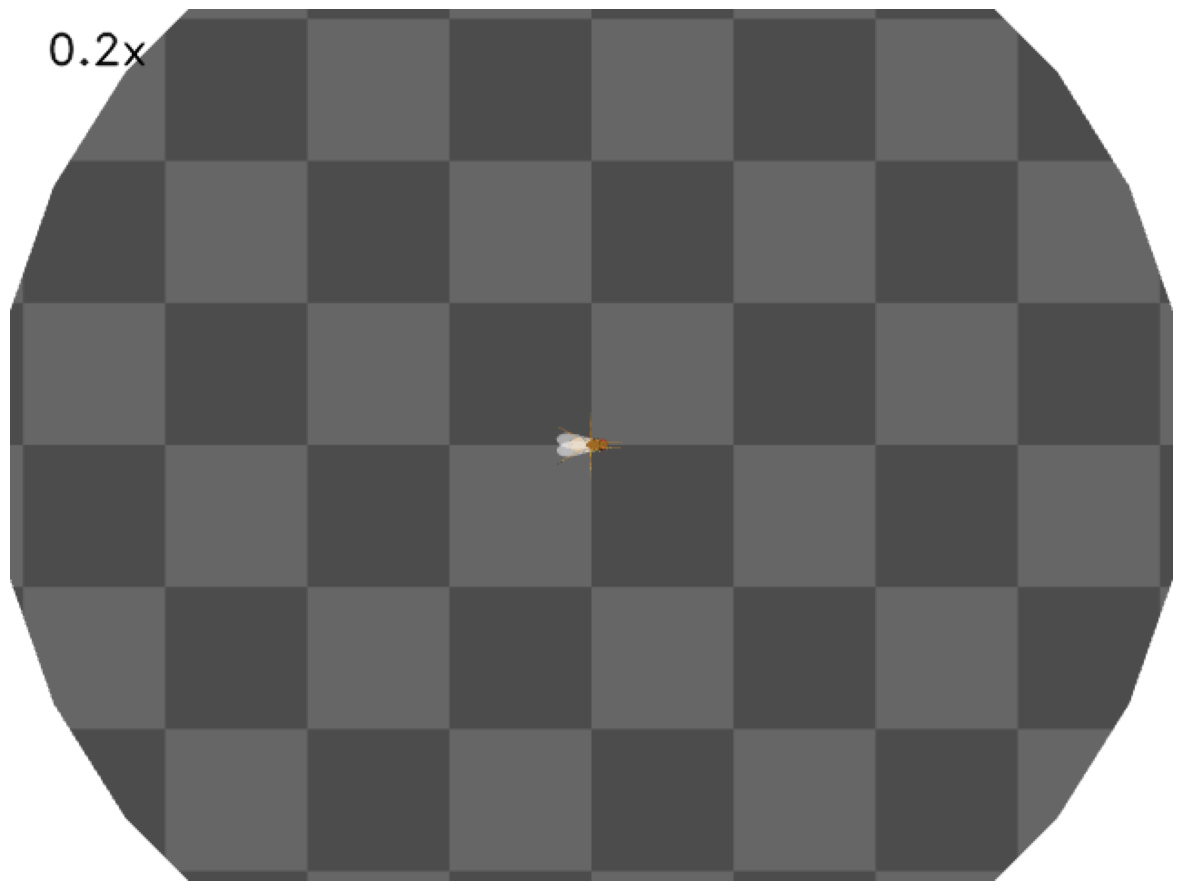

In [19]:
from IPython.display import Video

# Video(str(save_dir / "multiview.mp4"))

# plt.imshow(images[-1])
# show all cameras in a single big plot
plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(images, axis=1))
plt.axis("off")
plt.show()



# Video(str(save_dir / "single_fly.mp4"))
Video(str(save_dir / "cpg_controller.mp4"))

cpg controller
turning controller
hybrid controller
rule based contoller

arena with correct obstacles

backward-walking and turning from paper implemented in all controllers
randomized froward walking from paper implemented in all controllers

antenae and mechanical contact sensors, use fly attributes for this.

actuate antenae and head.

convert recordings to preprogrammed steps.


In [13]:
fly.get_observation(sim)
# fly.change_segment_color for when antenae are touched.
# pp.get_collision_geometries()

{'joints': array([[ 4.79667276e-01,  1.04959905e+00,  1.07087053e-01,
         -2.21419692e+00,  7.49956727e-01,  1.64541221e+00,
         -5.74112356e-01,  3.05318356e-01,  1.87357318e+00,
          8.03170085e-01, -1.56841528e+00, -8.67845565e-02,
          2.03343010e+00, -7.35673845e-01,  8.12290013e-01,
          2.46645570e+00,  4.68433827e-01, -1.54638243e+00,
         -2.48246983e-01,  1.81263804e+00, -2.31129751e-01,
          6.20310962e-01, -1.15395975e+00, -1.36735439e-01,
         -2.27889085e+00, -9.52231407e-01,  2.00244927e+00,
         -6.70218408e-01, -1.82581216e-01, -1.75531638e+00,
         -6.84071660e-01, -1.71454346e+00,  1.01744324e-01,
          2.08726215e+00, -6.36342287e-01,  5.62291682e-01,
         -2.45819426e+00, -4.39789474e-01, -1.61093163e+00,
          4.06307399e-01,  1.48844182e+00,  3.61068151e-03],
        [ 1.09215784e+01,  1.06888132e+01,  9.18356553e-02,
         -1.19320126e+01,  1.07459669e+01,  9.06565094e+00,
         -1.26921460e-01, -1.